# **Entrenamiento de redes neuronales profundas**

# Problema de los degradados que desaparecen/explotan

Observando la función de activación sigmoidea, se puede ver que cuando las entradas son grandes (negativas o positivas), la función se satura en 0 o 1, con una derivada extremadamente cercana a 0 (es decir, la curva es plana en ambos extremos). Por lo tanto, cuando el backpropagation se pone en marcha, prácticamente no tiene gradiente para propagarse a través de la red, y el poco gradiente que existe se va diluyendo a medida que la backpropagation avanza a través de las capas superiores, por lo que realmente no queda nada para las capas inferiores.

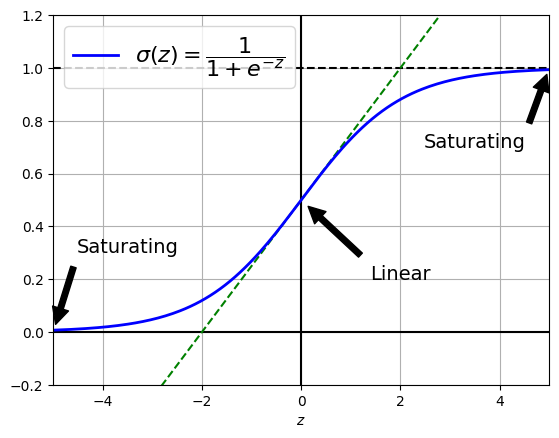

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

## Xavier and He Initialization

In [2]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [3]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

### Leaky ReLU

La función de activación ReLU se define como $LeakyReLU_α (z) = max(αz, z)$. El hiperparámetro α define el grado de "fuga" de la función: es la pendiente de la función para z < 0. Tener una pendiente para z < 0 garantiza que las ReLU con fugas nunca mueran; pueden entrar en un coma prolongado, pero tienen la oportunidad de despertar. Un artículo de 2015 de Bing Xu et al. comparaba diversas variantes de la función de activación ReLU, y una de sus conclusiones era que las variantes con fugas siempre superaban a la función de activación ReLU estricta. De hecho, establecer α = 0,2 (una fuga enorme) parecía dar como resultado un mejor rendimiento que α = 0,01 (una fuga pequeña). El artículo también evaluaba la función ReLU aleatoria con fugas (RReLU), en la que α se elige aleatoriamente en un rango determinado durante el entrenamiento y se fija en un valor medio durante las pruebas. RReLU también funcionó bastante bien y pareció actuar como regularizador, reduciendo el riesgo de sobreajuste del conjunto de entrenamiento. Por último, se evaluó el ReLU paramétrico con fugas (PReLU), en el que se autoriza el aprendizaje de α durante el entrenamiento: en lugar de ser un hiperparámetro, se convierte en un parámetro que puede modificarse mediante backpropagation como cualquier otro parámetro. Según los informes, PReLU supera ampliamente a ReLU en grandes conjuntos de datos de imágenes, pero en conjuntos de datos más pequeños corre el riesgo de sobreajustar el conjunto de entrenamiento.

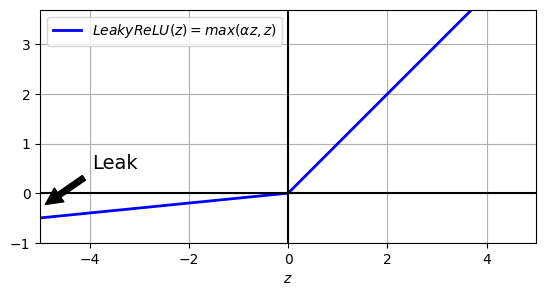

In [4]:

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [5]:
leaky_relu = tf.keras.layers.LeakyReLU(negative_slope=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

c:\Users\jamr1\Desktop\Clases_DS\Bootcamp_DS\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [6]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(alpha=0.2), 
    # [...]  # more layers
])

### ELU

Implementar ELU en TensorFlow es trivial, basta con especificar la función de activación al construir cada capa, y utilizar He inicialización:

In [7]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

Por defecto, los hiperparámetros de SELU (`scale` y `alpha`) se ajustan de tal forma que la media de salida de cada neurona se mantiene cercana a 0, y la desviación estándar se mantiene cercana a 1 (asumiendo que las entradas están estandarizadas con media 0 y desviación estándar 1 también, y se respetan otras restricciones). Usando esta función de activación, incluso una red neuronal profunda de 1.000 capas conserva aproximadamente la media 0 y la desviación estándar 1 en todas las capas, evitando el problema de la explosión/desvanecimiento de gradientes:

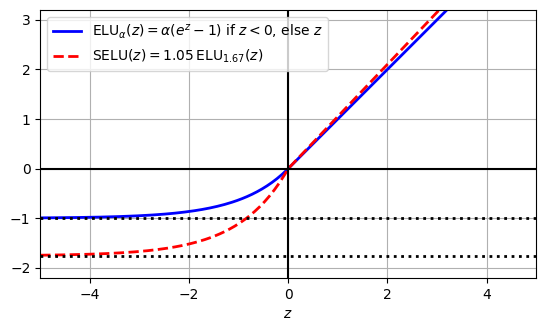

In [8]:

from scipy.special import erfc

# alfa y scale para auto normalizar con media 0 y desviación estándar 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

Utilizar SELU es muy sencillo:

In [9]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**Material extra: ejemplo de red autorregularizada con SELU**.

Vamos a crear una red neuronal para la Moda MNIST con 100 capas ocultas, utilizando la función de activación SELU:

In [10]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

c:\Users\jamr1\Desktop\Clases_DS\Bootcamp_DS\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Ahora vamos a entrenarlo. No olvides escalar las entradas a media 0 y desviación típica 1:

In [12]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [14]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [15]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4418 - loss: 1.4795 - val_accuracy: 0.6410 - val_loss: 0.9921
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6439 - loss: 0.9531 - val_accuracy: 0.6556 - val_loss: 0.8983
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6742 - loss: 0.8535 - val_accuracy: 0.7080 - val_loss: 0.7496
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7371 - loss: 0.7038 - val_accuracy: 0.7358 - val_loss: 0.6819
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7732 - loss: 0.6125 - val_accuracy: 0.7980 - val_loss: 0.5545


La red ha conseguido aprender, a pesar de lo profunda que es. Ahora mira lo que ocurre si intentamos utilizar la función de activación ReLU en su lugar:

In [16]:
tf.random.set_seed(42)

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2038 - loss: 2.0450 - val_accuracy: 0.4284 - val_loss: 1.4130
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4256 - loss: 1.3723 - val_accuracy: 0.5804 - val_loss: 1.0375
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5567 - loss: 1.0451 - val_accuracy: 0.5028 - val_loss: 1.1760
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5885 - loss: 0.9851 - val_accuracy: 0.6122 - val_loss: 0.9879
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6457 - loss: 0.8836 - val_accuracy: 0.6600 - val_loss: 0.8878


No es genial en absoluto, sufrimos el problema de los gradientes que se desvanecen/explotan.

### GELU, Swish and Mish

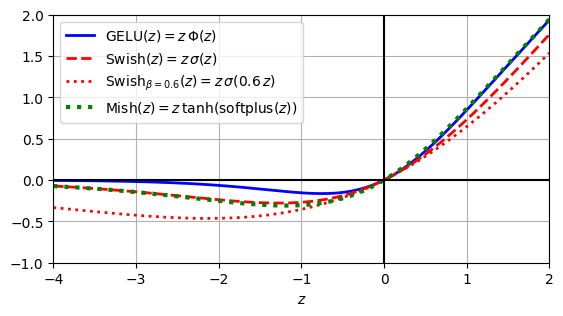

In [20]:

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

# Batch Normalization

Aunque el uso de la inicialización He junto con ReLU (o cualquiera de sus variantes) puede reducir significativamente el peligro de los problemas de gradientes desvanecidos/explosivos al principio del entrenamiento, no garantiza que no vuelvan a aparecer durante el entrenamiento.

En un artículo de 2015, 12 Sergey Ioffe y Christian Szegedy propusieron una técnica llamada normalización por lotes (BN) que aborda estos problemas. La técnica consiste en añadir una operación en el modelo justo antes o después de la función de activación de cada capa oculta. Esta operación simplemente centra en cero y normaliza cada entrada, luego escala y desplaza el resultado utilizando dos nuevos vectores de parámetros por capa: uno para la escala y otro para el desplazamiento. En otras palabras, la operación permite al modelo aprender la escala y la media óptimas de cada una de las entradas de la capa. En muchos casos, si se añade una capa BN como primera capa de la red neuronal, no es necesario estandarizar el conjunto de entrenamiento. Es decir, no hay necesidad de StandardScaler o Normalization; la capa BN lo hará por usted (bueno, aproximadamente, ya que sólo mira un lote a la vez, y también puede reescalar y desplazar cada característica de entrada).

Para centrar a cero y normalizar las entradas, el algoritmo necesita estimar la media y la desviación estándar de cada entrada. Para ello, evalúa la media y la desviación estándar de la entrada en el minilote actual (de ahí el nombre de "normalización por lotes").

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [24]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [26]:
# sólo demuestran que el modelo funciona 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7564 - loss: 0.7161 - val_accuracy: 0.8530 - val_loss: 0.4003
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8581 - loss: 0.4035 - val_accuracy: 0.8636 - val_loss: 0.3707


A veces aplicar BN antes de la función de activación funciona mejor (hay un debate sobre este tema). Por otra parte, la capa antes de una capa `BatchNormalization` no necesita tener términos de sesgo, ya que la capa `BatchNormalization` algunos también, sería un desperdicio de parámetros, por lo que puede establecer `use_bias=False` al crear esas capas:

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [30]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7325 - loss: 0.8350 - val_accuracy: 0.8434 - val_loss: 0.4337
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8486 - loss: 0.4362 - val_accuracy: 0.8580 - val_loss: 0.3900


## Gradient Clipping

Otra técnica para mitigar el problema de la explosión de gradientes es recortar los gradientes durante la backpropagation para que nunca superen algún umbral. Esta técnica se utiliza generalmente en redes neuronales recurrentes, donde el uso de la normalización por lotes es complicado.

Todos los `tf.keras.optimizers` aceptan argumentos `clipnorm` o `clipvalue`:

In [31]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [32]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reutilización de capas preentrenadas

### Reusing a Keras model

Vamos a dividir el conjunto de entrenamiento MNIST de moda en dos:
* X_train_A: todas las imágenes de todos los artículos excepto camisetas y jerseys (clases 0 y 2).
* X_train_B": un conjunto de entrenamiento mucho más pequeño, con sólo las 200 primeras imágenes de camisetas y jerseys.

El conjunto de validación y el conjunto de prueba también se dividen de esta forma, pero sin restringir el número de imágenes.

Entrenaremos un modelo en el conjunto A (tarea de clasificación con 8 clases), e intentaremos reutilizarlo para abordar el conjunto B (clasificación binaria). Esperamos transferir un poco de conocimiento de la tarea A a la tarea B, ya que las clases del conjunto A (pantalones, vestidos, abrigos, sandalias, camisas, zapatillas, bolsos y botines) son algo similares a las clases del conjunto B (camisetas/tops y jerseys). Sin embargo, como estamos utilizando capas "densas", sólo pueden reutilizarse los patrones que aparecen en el mismo lugar.

In [34]:
# dividir Fashion MNIST en tareas A y B, luego entrenar y guardar
# el modelo A en "mi_modelo_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

Epoch 1/20


c:\Users\jamr1\Desktop\Clases_DS\Bootcamp_DS\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5203 - loss: 1.4937 - val_accuracy: 0.7824 - val_loss: 0.6884
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7961 - loss: 0.6416 - val_accuracy: 0.8366 - val_loss: 0.5144
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8412 - loss: 0.5004 - val_accuracy: 0.8566 - val_loss: 0.4400
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8612 - loss: 0.4324 - val_accuracy: 0.8651 - val_loss: 0.3979
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8740 - loss: 0.3917 - val_accuracy: 0.8694 - val_loss: 0.3705
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8804 - loss: 0.3640 - val_accuracy: 0.8747 - val_loss: 0.3511
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8850 - loss: 0.3440 - val_accuracy: 0.8797 - val_loss: 0.3367
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8893 - loss: 0.3289 - val_accurac

In [35]:
# entrenar y evaluar el modelo B, sin reutilizar el modelo A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4173 - loss: 0.7571 - val_accuracy: 0.4837 - val_loss: 0.7096
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4282 - loss: 0.7283 - val_accuracy: 0.5015 - val_loss: 0.6848
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4390 - loss: 0.7009 - val_accuracy: 0.5391 - val_loss: 0.6605
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4910 - loss: 0.6744 - val_accuracy: 0.6083 - val_loss: 0.6370
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6126 - loss: 0.6493 - val_accuracy: 0.6874 - val_loss: 0.6151
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6744 - loss: 0.6257 - val_accuracy: 0.7468 - val_loss: 0.5946
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7157 - loss: 0.6036 - val_accuracy: 0.7873 - val_loss: 0.5762
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7620 - loss: 0.5834 - val_accuracy: 0.8180 - val_loss: 0.5596


[0.4397251307964325, 0.906000018119812]

El modelo B alcanza una precisión del 91,85% en el conjunto de pruebas. Ahora vamos a intentar reutilizar el modelo A preentrenado.

In [37]:
model_A = tf.keras.models.load_model("my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Ten en cuenta que `model_B_on_A` y `model_A` comparten capas ahora, así que cuando entrenemos uno, se actualizarán ambos modelos. Si queremos evitar esto, tenemos que construir "model_B_on_A" sobre un "clon" de "model_A":

In [38]:
tf.random.set_seed(42)

In [39]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [40]:
# crear modelo_B_on_A igual que en la celda anterior
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [42]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5680 - loss: 1.8190 - val_accuracy: 0.4995 - val_loss: 1.3082
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4989 - loss: 1.1763 - val_accuracy: 0.3620 - val_loss: 0.9906
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3298 - loss: 0.9826 - val_accuracy: 0.2572 - val_loss: 0.9264
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2976 - loss: 0.9452 - val_accuracy: 0.2671 - val_loss: 0.8988
Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3407 - loss: 0.8833 - val_accuracy: 0.5361 - val_loss: 0.7490
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5835 - loss: 0.7365 - val_accuracy: 0.6894 - val_loss: 0.6458
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7454 - loss: 0.6342 - val_accuracy: 0.7695 - val_loss: 0.5737
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7764 - loss: 0.5615 - val_accuracy: 0.8239 - val_loss: 0.5205
Epoc

¿Cuál es el veredicto final?

In [43]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9175 - loss: 0.3004


[0.31137195229530334, 0.9179999828338623]

Estupendo. Conseguimos un poco de transferencia: la precisión del modelo subió 2 puntos porcentuales, del 91,85% al 93,85%. Esto significa que la tasa de error bajó casi un 25%:

In [44]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

# Faster Optimizers

Entrenar una red neuronal profunda muy grande puede ser dolorosamente lento. Hasta ahora hemos visto cuatro formas de acelerar el entrenamiento (y alcanzar una solución mejor): aplicar una buena estrategia de inicialización para los pesos de conexión, usar una buena función de activación, usar normalización por lotes y reutilizar partes de una red preentrenada (posiblemente construida para una tarea auxiliar o usando aprendizaje no supervisado). Otro enorme aumento de la velocidad se consigue utilizando un optimizador más rápido que el optimizador normal de descenso de gradiente. En esta sección presentaremos los algoritmos de optimización más populares: momentum, gradiente acelerado de Nesterov, AdaGrad, RMSProp y, por último, Adam y sus variantes.

In [45]:
# extra code - una pequeña función para probar un optimizador en Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [47]:
history_sgd = build_and_train_model(optimizer) 

Epoch 1/10


c:\Users\jamr1\Desktop\Clases_DS\Bootcamp_DS\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6700 - loss: 0.9866 - val_accuracy: 0.8176 - val_loss: 0.5062
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8296 - loss: 0.4862 - val_accuracy: 0.8352 - val_loss: 0.4547
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8483 - loss: 0.4343 - val_accuracy: 0.8450 - val_loss: 0.4265
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8581 - loss: 0.4038 - val_accuracy: 0.8540 - val_loss: 0.4034
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8660 - loss: 0.3823 - val_accuracy: 0.8570 - val_loss: 0.3894
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8722 - loss: 0.3651 - val_accuracy: 0.8584 - val_loss: 0.3796
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8765 - loss: 0.3510 - val_accuracy: 0.8632 - val_loss: 0.3710
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8811 - loss: 0.3389 - val_accurac

## Momentum optimization

Imaginemos una bola de bolos rodando por una pendiente suave sobre una superficie lisa: empezará despacio, pero cogerá impulso rápidamente hasta que alcance la velocidad terminal (si hay algo de fricción o resistencia del aire). Esta es la idea central de la optimización del impulso, propuesta por Boris Polyak en 1964. Por el contrario, el descenso por pendiente regular dará pequeños pasos cuando la pendiente sea suave y grandes pasos cuando la pendiente sea pronunciada, pero nunca cogerá velocidad. Como resultado, el descenso de gradiente regular es generalmente mucho más lento para alcanzar el mínimo que la optimización de impulso.

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [49]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6707 - loss: 1.0045 - val_accuracy: 0.8174 - val_loss: 0.5076
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8298 - loss: 0.4878 - val_accuracy: 0.8408 - val_loss: 0.4499
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8487 - loss: 0.4347 - val_accuracy: 0.8528 - val_loss: 0.4199
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8599 - loss: 0.4030 - val_accuracy: 0.8566 - val_loss: 0.4042
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8665 - loss: 0.3805 - val_accuracy: 0.8584 - val_loss: 0.3925
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8723 - loss: 0.3635 - val_accuracy: 0.8620 - val_loss: 0.3831
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8774 - loss: 0.3492 - val_accuracy: 0.8626 - val_loss: 0.3747
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8818 - loss: 0.3366 - 

## Nesterov Accelerated Gradient

Una pequeña variante de la optimización del momento, propuesta por Yurii Nesterov en 1983, es casi siempre más rápida que la optimización del momento normal. El método del gradiente acelerado de Nesterov (NAG), también conocido como optimización del momento de Nesterov, mide el gradiente de la función de coste no en la posición local θ, sino ligeramente por delante en la dirección del momento, en θ + βm.


In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [51]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6721 - loss: 0.9958 - val_accuracy: 0.8228 - val_loss: 0.4964
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8330 - loss: 0.4755 - val_accuracy: 0.8376 - val_loss: 0.4447
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8493 - loss: 0.4258 - val_accuracy: 0.8438 - val_loss: 0.4211
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8583 - loss: 0.3979 - val_accuracy: 0.8468 - val_loss: 0.4093
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8654 - loss: 0.3782 - val_accuracy: 0.8502 - val_loss: 0.3993
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8709 - loss: 0.3628 - val_accuracy: 0.8540 - val_loss: 0.3901
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8755 - loss: 0.3496 - val_accuracy: 0.8568 - val_loss: 0.3842
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8798 - loss: 0.3381 - 

## AdaGrad

Consideremos de nuevo el problema del cuenco alargado: el descenso por gradiente empieza bajando rápidamente por la pendiente más pronunciada, que no apunta directamente hacia el óptimo global, y luego baja muy lentamente hasta el fondo del valle. Sería bueno que el algoritmo pudiera corregir su dirección antes para apuntar un poco más hacia el óptimo global. El algoritmo AdaGrad17 consigue esta corrección reduciendo la escala del vector gradiente a lo largo de las cotas más empinadas.


In [52]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [53]:
history_adagrad = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5399 - loss: 1.4124 - val_accuracy: 0.7712 - val_loss: 0.7040
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7734 - loss: 0.6831 - val_accuracy: 0.8046 - val_loss: 0.5977
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8025 - loss: 0.5967 - val_accuracy: 0.8186 - val_loss: 0.5499
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8154 - loss: 0.5532 - val_accuracy: 0.8252 - val_loss: 0.5214
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8237 - loss: 0.5254 - val_accuracy: 0.8284 - val_loss: 0.5013
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8295 - loss: 0.5056 - val_accuracy: 0.8324 - val_loss: 0.4856
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8339 - loss: 0.4902 - val_accuracy: 0.8340 - val_loss: 0.4735
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8368 - loss: 0.4779 - 

## RMSProp

Como hemos visto, AdaGrad corre el riesgo de ralentizarse demasiado rápido y no converger nunca al óptimo global. El algoritmo RMSProp18 soluciona esto acumulando sólo los gradientes de las iteraciones más recientes, en lugar de todos los gradientes desde el principio del entrenamiento. Para ello, utiliza un decaimiento exponencial en el primer paso.

In [54]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [55]:
history_rmsprop = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7630 - loss: 0.6646 - val_accuracy: 0.8428 - val_loss: 0.4135
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8547 - loss: 0.4031 - val_accuracy: 0.8432 - val_loss: 0.4158
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8693 - loss: 0.3698 - val_accuracy: 0.8486 - val_loss: 0.4244
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8769 - loss: 0.3524 - val_accuracy: 0.8666 - val_loss: 0.3946
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8801 - loss: 0.3492 - val_accuracy: 0.8412 - val_loss: 0.4914
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8790 - loss: 0.3444 - val_accuracy: 0.8542 - val_loss: 0.4979
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8817 - loss: 0.3421 - val_accuracy: 0.8452 - val_loss: 0.5901
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8850 - loss: 0.3383 - 

## Adam Optimization

Adam, que significa estimación adaptativa del momento, combina las ideas de la optimización del momento y RMSProp: al igual que la optimización del momento, realiza un seguimiento de una media exponencialmente decreciente de gradientes pasados; y al igual que RMSProp, realiza un seguimiento de una media exponencialmente decreciente de gradientes pasados al cuadrado. Estas son estimaciones de la media y la varianza (no centrada) de los gradientes. La media se suele llamar primer momento, mientras que la varianza se suele llamar segundo momento, de ahí el nombre del algoritmo.

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [57]:
history_adam = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7695 - loss: 0.6493 - val_accuracy: 0.8370 - val_loss: 0.4223
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8591 - loss: 0.3890 - val_accuracy: 0.8440 - val_loss: 0.3997
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8742 - loss: 0.3474 - val_accuracy: 0.8504 - val_loss: 0.3807
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8817 - loss: 0.3215 - val_accuracy: 0.8590 - val_loss: 0.3657
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8903 - loss: 0.2984 - val_accuracy: 0.8714 - val_loss: 0.3425
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8950 - loss: 0.2838 - val_accuracy: 0.8680 - val_loss: 0.3703
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.2715 - val_accuracy: 0.8746 - val_loss: 0.3455
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9050 - loss: 0.2575 - 

**Adamax Optimization**

Adam reduce las actualizaciones de parámetros por la norma ℓ2 de los gradientes de tiempo decaído (recordemos que la norma ℓ2 es la raíz cuadrada de la suma de cuadrados).

In [58]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [59]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7573 - loss: 0.7135 - val_accuracy: 0.8248 - val_loss: 0.4717
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8543 - loss: 0.4157 - val_accuracy: 0.8390 - val_loss: 0.4188
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8690 - loss: 0.3692 - val_accuracy: 0.8532 - val_loss: 0.3830
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8784 - loss: 0.3411 - val_accuracy: 0.8558 - val_loss: 0.3731
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8844 - loss: 0.3200 - val_accuracy: 0.8604 - val_loss: 0.3630
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8906 - loss: 0.3038 - val_accuracy: 0.8646 - val_loss: 0.3575
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8952 - loss: 0.2902 - val_accuracy: 0.8660 - val_loss: 0.3519
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.2782 - 

**Nadam Optimization**

La optimización Nadam es la optimización Adam más el truco Nesterov, por lo que a menudo convergerá ligeramente más rápido que Adam. En su informe de presentación de esta técnica, el investigador Timothy Dozat compara muchos optimizadores diferentes en varias tareas y descubre que Nadam suele superar a Adam, pero a veces es superado por RMSProp.

In [60]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [61]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7829 - loss: 0.6250 - val_accuracy: 0.8440 - val_loss: 0.4100
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8625 - loss: 0.3768 - val_accuracy: 0.8596 - val_loss: 0.3721
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8771 - loss: 0.3363 - val_accuracy: 0.8562 - val_loss: 0.3856
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8867 - loss: 0.3092 - val_accuracy: 0.8566 - val_loss: 0.3856
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8904 - loss: 0.2902 - val_accuracy: 0.8708 - val_loss: 0.3507
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.2743 - val_accuracy: 0.8746 - val_loss: 0.3449
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9010 - loss: 0.2607 - val_accuracy: 0.8758 - val_loss: 0.3524
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9078 - loss: 0.2477 - 

**AdamW Optimization**

Es una variante de Adam que integra una técnica de regularización llamada decaimiento del peso. El decaimiento del peso reduce el tamaño de los pesos del modelo en cada iteración de entrenamiento multiplicándolos por un factor de decaimiento como 0,99. Esto puede recordarle a la regularización ℓ2, que también pretende mantener los pesos pequeños, y de hecho puede demostrarse matemáticamente que la regularización ℓ2 es equivalente al decaimiento del peso cuando se utiliza SGD. Sin embargo, cuando se utiliza Adam o sus variantes, la regularización ℓ2 y el decaimiento del peso no son equivalentes: en la práctica, la combinación de Adam con la regularización ℓ2 da lugar a modelos que a menudo no generalizan tan bien como los producidos por SGD. AdamW soluciona este problema combinando adecuadamente Adam con el decaimiento del peso.


Nota: Desde TF 1.12, `AdamW` ya no es experimental. Está disponible en `tf.keras.optimizers.AdamW` en lugar de `tf.keras.optimizers.experimental.AdamW`.

In [62]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [63]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7729 - loss: 0.6397 - val_accuracy: 0.8320 - val_loss: 0.4312
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8569 - loss: 0.3887 - val_accuracy: 0.8326 - val_loss: 0.4163
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8730 - loss: 0.3444 - val_accuracy: 0.8486 - val_loss: 0.3876
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8815 - loss: 0.3188 - val_accuracy: 0.8580 - val_loss: 0.3734
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8907 - loss: 0.2987 - val_accuracy: 0.8664 - val_loss: 0.3537
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8940 - loss: 0.2817 - val_accuracy: 0.8702 - val_loss: 0.3684
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8986 - loss: 0.2687 - val_accuracy: 0.8750 - val_loss: 0.3578
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9033 - loss: 0.2542 - 

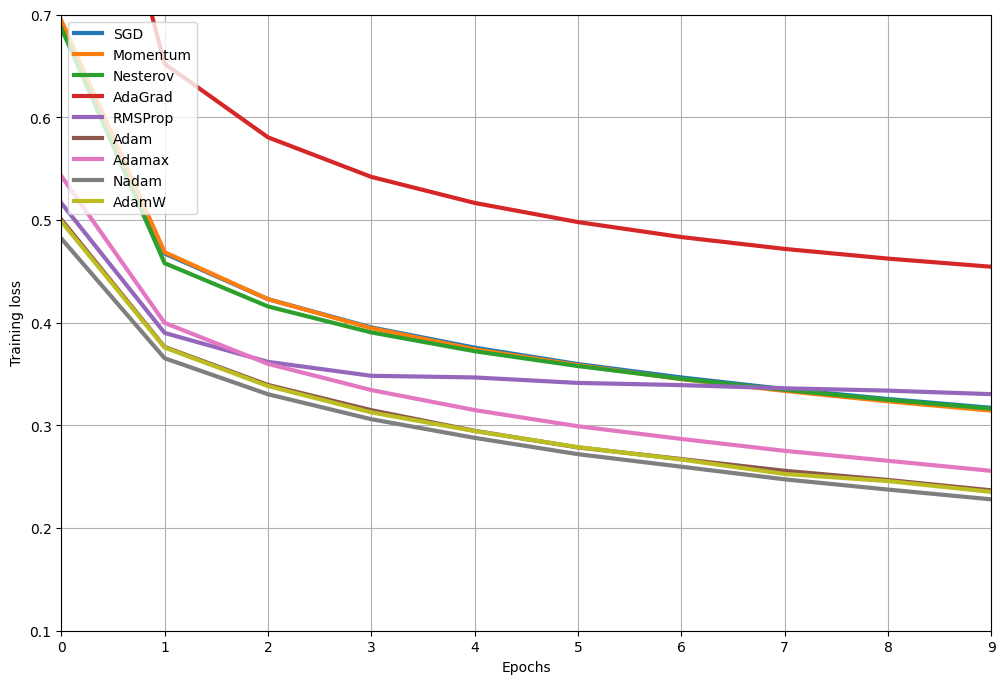

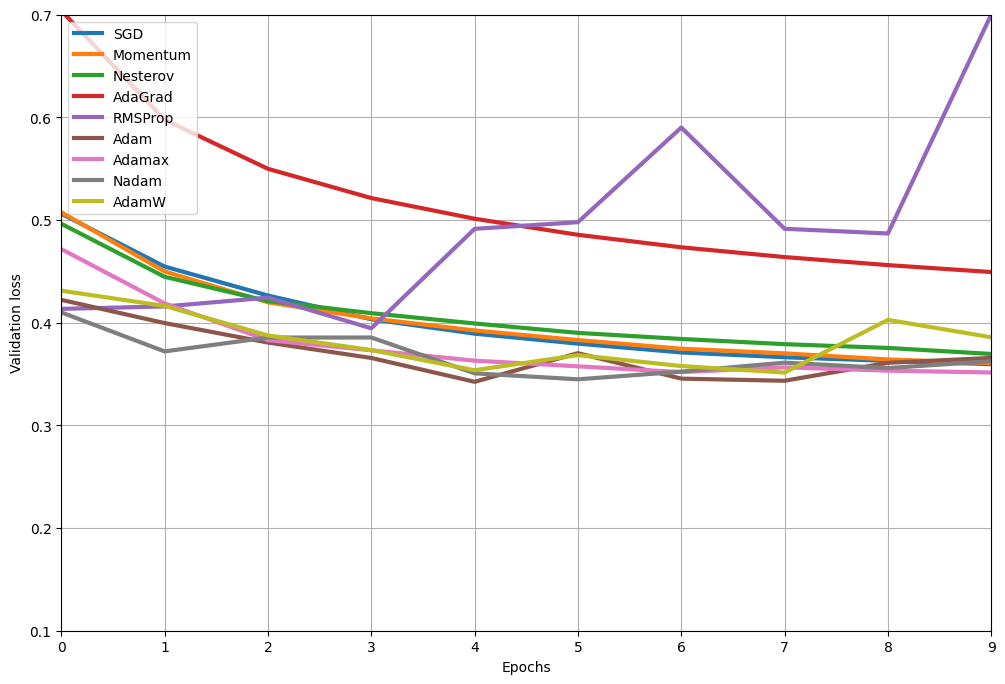

In [64]:
# visualizar las curvas de aprendizaje de todos los optimizadores

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

Encontrar una buena tasa de aprendizaje es muy importante. Si la ajusta demasiado alta, el entrenamiento puede divergir. Si la fijas demasiado baja, el entrenamiento convergerá eventualmente al óptimo, pero tardará mucho tiempo. Si lo estableces ligeramente demasiado alto, progresará muy rápido al principio, pero acabará bailando alrededor del óptimo y nunca se asentará realmente. Si dispone de un presupuesto de cálculo limitado, es posible que tenga que interrumpir el entrenamiento antes de que haya convergido correctamente, lo que dará lugar a una solución subóptima.


### Programación de energía

```python
learning_rate = initial_learning_rate / (1 + step / decay_steps)**power
```

Keras usa `power = 1`.

**Nota**: El argumento `decay` en los optimizadores está obsoleto. Los antiguos optimizadores que implementan el argumento `decay` siguen estando disponibles en `tf.keras.optimizers.legacy`, pero en su lugar deberías utilizar los programadores de `tf.keras.optimizers.schedules`.

In [65]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

El programador `InverseTimeDecay` utiliza `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)`. Si se establece `staircase=True`, se sustituye `step / decay_step` por `floor(step / decay_step)`.

In [66]:
history_power_scheduling = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6823 - loss: 0.9583 - val_accuracy: 0.8316 - val_loss: 0.4899
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8283 - loss: 0.4877 - val_accuracy: 0.8412 - val_loss: 0.4463
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8464 - loss: 0.4366 - val_accuracy: 0.8468 - val_loss: 0.4289
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8557 - loss: 0.4094 - val_accuracy: 0.8492 - val_loss: 0.4163
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8612 - loss: 0.3912 - val_accuracy: 0.8514 - val_loss: 0.4069
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8656 - loss: 0.3774 - val_accuracy: 0.8540 - val_loss: 0.3981
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8698 - loss: 0.3663 - val_accuracy: 0.8576 - val_loss: 0.3905
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8726 - loss: 0.3572 - 

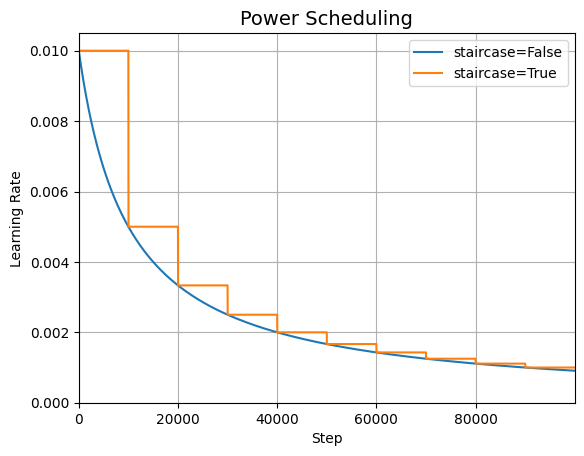

In [67]:
# esta celda traza la programación de potencia con staircase=True o False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Programación exponencial

```python
learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)
```

In [68]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [69]:
history_exponential_scheduling = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6905 - loss: 0.9273 - val_accuracy: 0.8340 - val_loss: 0.4795
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8284 - loss: 0.4921 - val_accuracy: 0.8458 - val_loss: 0.4329
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8455 - loss: 0.4406 - val_accuracy: 0.8552 - val_loss: 0.4120
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8553 - loss: 0.4133 - val_accuracy: 0.8590 - val_loss: 0.4005
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8622 - loss: 0.3951 - val_accuracy: 0.8584 - val_loss: 0.3900
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8670 - loss: 0.3822 - val_accuracy: 0.8624 - val_loss: 0.3830
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8697 - loss: 0.3721 - val_accuracy: 0.8638 - val_loss: 0.3767
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8721 - loss: 0.3645 - 

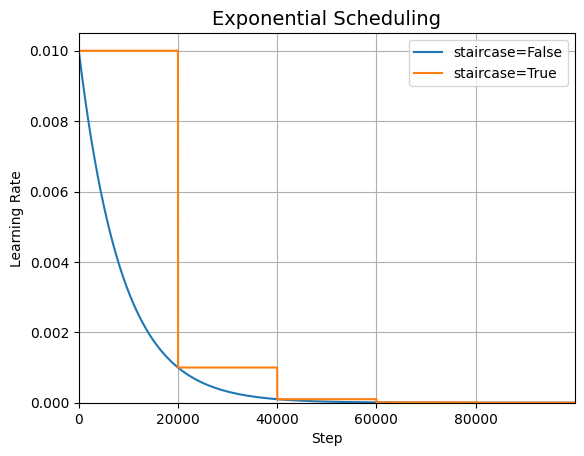

In [70]:
# esta celda traza una programación exponencial

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras también proporciona una clase de callback `LearningRateScheduler` que te permite definir tu propia función de programación. Veamos cómo usarla para implementar el decaimiento exponencial. Tenga en cuenta que en este caso la tasa de aprendizaje sólo cambia en cada época, no en cada paso:

In [71]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [72]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [73]:
# construir y compilar un modelo para Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [74]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6811 - loss: 0.9521 - val_accuracy: 0.8202 - val_loss: 0.5023 - learning_rate: 0.0100
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8280 - loss: 0.4931 - val_accuracy: 0.8324 - val_loss: 0.4590 - learning_rate: 0.0089
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8480 - loss: 0.4393 - val_accuracy: 0.8406 - val_loss: 0.4340 - learning_rate: 0.0079
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8558 - loss: 0.4098 - val_accuracy: 0.8468 - val_loss: 0.4173 - learning_rate: 0.0071
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8629 - loss: 0.3899 - val_accuracy: 0.8538 - val_loss: 0.4006 - learning_rate: 0.0063
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8677 - loss: 0.3746 - val_accuracy: 0.8592 - val_loss: 0.3902 - learning_rate: 0.0056
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8704 - l

Alternativamente, la función de programación puede tomar el ritmo de aprendizaje actual como segundo argumento:

In [75]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

### Programación constante a trozos

In [79]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [80]:
history_piecewise_scheduling = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6758 - loss: 0.9734 - val_accuracy: 0.8298 - val_loss: 0.4852
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8273 - loss: 0.4905 - val_accuracy: 0.8402 - val_loss: 0.4409
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8465 - loss: 0.4346 - val_accuracy: 0.8502 - val_loss: 0.4189
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8568 - loss: 0.4029 - val_accuracy: 0.8534 - val_loss: 0.4108
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8641 - loss: 0.3810 - val_accuracy: 0.8538 - val_loss: 0.4056
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8696 - loss: 0.3638 - val_accuracy: 0.8560 - val_loss: 0.3955
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8737 - loss: 0.3497 - val_accuracy: 0.8596 - val_loss: 0.3899
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8774 - loss: 0.3376 - 

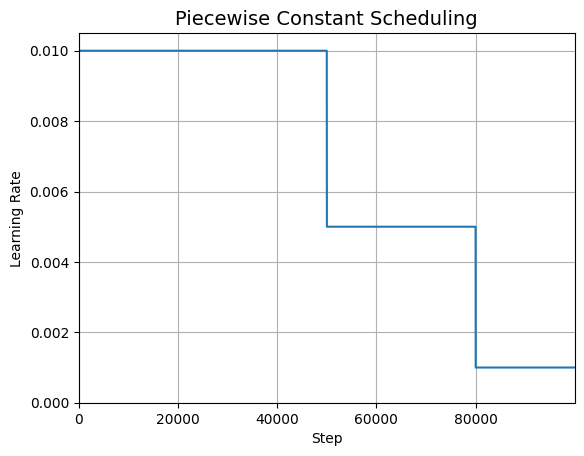

In [81]:
# esta celda traza una programación constante a trozos

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Al igual que hicimos con la programación exponencial, también podríamos implementar manualmente la programación constante a trozos:

In [82]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [83]:
# esta celda demuestra una forma más general de definir
# programación constante a trozos.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [84]:
# utilizar un tf.keras.callbacks.LearningRateScheduler como antes

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7547 - loss: 0.6891 - val_accuracy: 0.8112 - val_loss: 0.5048 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8423 - loss: 0.4535 - val_accuracy: 0.8246 - val_loss: 0.4935 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8475 - loss: 0.4259 - val_accuracy: 0.8170 - val_loss: 0.5719 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8544 - loss: 0.4141 - val_accuracy: 0.8406 - val_loss: 0.4320 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8579 - loss: 0.4071 - val_accuracy: 0.8534 - val_loss: 0.4033 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8704 - loss: 0.3615 - val_accuracy: 0.8596 - val_loss: 0.3922 - learning_rate: 0.0050
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8748 - l

Hemos visto `InverseTimeDecay`, `ExponentialDecay`, y `PiecewiseConstantDecay`. Algunos programadores más están disponibles en `tf.keras.optimizers.schedules`, aquí está la lista completa:

In [85]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} - {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay - A `LearningRateSchedule` that uses a cosine decay with optional warmup.
• CosineDecayRestarts - A `LearningRateSchedule` that uses a cosine decay schedule with restarts.
• ExponentialDecay - A `LearningRateSchedule` that uses an exponential decay schedule.
• InverseTimeDecay - A `LearningRateSchedule` that uses an inverse time decay schedule.
• LearningRateSchedule - The learning rate schedule base class.
• PiecewiseConstantDecay - A `LearningRateSchedule` that uses a piecewise constant decay schedule.
• PolynomialDecay - A `LearningRateSchedule` that uses a polynomial decay schedule.


### Programación del rendimiento

In [86]:
# construir y compilar el modelo

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [87]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6762 - loss: 0.9684 - val_accuracy: 0.8084 - val_loss: 0.5177 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8268 - loss: 0.4924 - val_accuracy: 0.8198 - val_loss: 0.4769 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8474 - loss: 0.4338 - val_accuracy: 0.8302 - val_loss: 0.4555 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8567 - loss: 0.4009 - val_accuracy: 0.8408 - val_loss: 0.4363 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8635 - loss: 0.3780 - val_accuracy: 0.8484 - val_loss: 0.4175 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8704 - loss: 0.3606 - val_accuracy: 0.8496 - val_loss: 0.4023 - learning_rate: 0.0100
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8739 - l

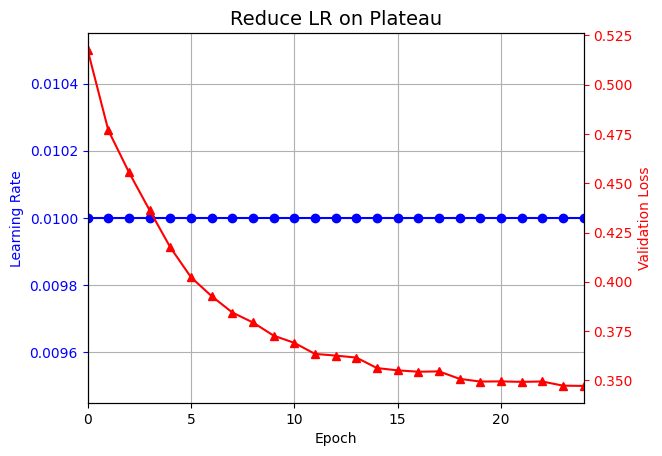

In [92]:
# esta celda traza la programación del rendimiento

plt.plot(history.epoch, history.history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

El callback personalizado `ExponentialLearningRate` actualiza la tasa de aprendizaje durante el entrenamiento, al final de cada lote. La multiplica por un "factor" constante. También guarda la tasa de aprendizaje y la pérdida en cada lote. Dado que `logs["loss"]` es en realidad la pérdida media desde el inicio de la época, y queremos guardar la pérdida del lote en su lugar, debemos calcular la media por el número de lotes desde el inicio de la época para obtener la pérdida total hasta el momento, luego restamos la pérdida total en el lote anterior para obtener la pérdida del lote actual.

In [93]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

La función `find_learning_rate()` entrena el modelo utilizando la llamada de retorno `ExponentialLearningRate`, y devuelve las tasas de aprendizaje y las pérdidas por lotes correspondientes. Al final, restaura el modelo y su optimizador a su estado inicial.

In [94]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

La función `plot_lr_vs_loss()` representa las tasas de aprendizaje frente a las pérdidas. La tasa de aprendizaje óptima para usar como tasa de aprendizaje máxima en 1cycle está cerca de la parte inferior de la curva.

In [95]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Construyamos un sencillo modelo Fashion MNIST y compilémoslo:

In [96]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

c:\Users\jamr1\Desktop\Clases_DS\Bootcamp_DS\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


El callback personalizado `OneCycleScheduler` actualiza la tasa de aprendizaje al principio de cada lote. Aplica la lógica descrita en el libro: aumenta la tasa de aprendizaje linealmente durante aproximadamente la mitad del entrenamiento, luego la reduce linealmente de vuelta a la tasa de aprendizaje inicial y, por último, la reduce linealmente hasta cerca de cero para la última parte del entrenamiento.

In [98]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

# Evitar el sobreajuste mediante la regularización

## $\ell_1$ and $\ell_2$ regularization

In [100]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

O utilice `l1(0,1)` para la regularización ℓ<sub>1</sub> con un factor de 0,1, o `l1_l2(0,1, 0,01)` tanto para la regularización ℓ<sub>1</sub> como para la regularización ℓ<sub>2</sub>, con factores 0,1 y 0,01 respectivamente.

In [101]:
tf.random.set_seed(42) 

In [102]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [103]:
# compilar y entrenar el modelo
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7056 - loss: 4.1317 - val_accuracy: 0.8216 - val_loss: 1.8755
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8114 - loss: 1.6349 - val_accuracy: 0.8234 - val_loss: 1.1197


## Dropout

Dropout es una de las técnicas de regularización más populares para redes neuronales profundas. Se propuso en un artículo de Geoffrey Hinton et al. en 2012 y se detalló en un artículo de 2014 de Nitish Srivastava et al., y ha demostrado ser muy eficaz: muchas redes neuronales de última generación utilizan dropout, ya que les proporciona un aumento de precisión del 1%-2%. Puede que no parezca mucho, pero cuando un modelo ya tiene una precisión del 95 %, conseguir un aumento de la precisión del 2 % significa reducir la tasa de error en casi un 40 % (pasar de un 5 % de error a aproximadamente un 3 %).

In [104]:
tf.random.set_seed(42)  

In [105]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [106]:

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6761 - loss: 0.8780 - val_accuracy: 0.8236 - val_loss: 0.4630
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8058 - loss: 0.5266 - val_accuracy: 0.8488 - val_loss: 0.4084
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8258 - loss: 0.4827 - val_accuracy: 0.8528 - val_loss: 0.3949
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8341 - loss: 0.4587 - val_accuracy: 0.8582 - val_loss: 0.3856
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8388 - loss: 0.4385 - val_accuracy: 0.8558 - val_loss: 0.3818
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8444 - loss: 0.4287 - val_accuracy: 0.8558 - val_loss: 0.3750
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8453 - loss: 0.4180 - val_accuracy: 0.8638 - val_loss: 0.3580
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8480 - loss: 0.4116 - 

Parece que la precisión del entrenamiento es menor que la de la validación, pero esto se debe a que el abandono sólo está activo durante el entrenamiento. Si evaluamos el modelo en el conjunto de entrenamiento después del entrenamiento (es decir, con el abandono desactivado), obtendremos la precisión de entrenamiento "real", que es ligeramente superior a la precisión de validación y a la precisión de prueba:

In [107]:
model.evaluate(X_train, y_train)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8883 - loss: 0.3027


[0.3049008548259735, 0.8880545496940613]

In [108]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8659 - loss: 0.3580


[0.3620859384536743, 0.8632000088691711]

**Nota**: asegúrate de usar `AlphaDropout` en lugar de `Dropout` si quieres construir una red neuronal autonormalizadora usando SELU.

## MC Dropout

En 2016, un artículo28 de Yarin Gal y Zoubin Ghahramani añadió algunas buenas razones más para utilizar el abandono:

- En primer lugar, el artículo estableció una profunda conexión entre las redes de abandono (es decir, las redes neuronales que contienen capas de abandono) y la inferencia bayesiana aproximada,29 dando a la deserción una sólida justificación matemática.

- En segundo lugar, los autores introdujeron una potente técnica denominada MC dropout, que
puede aumentar el rendimiento de cualquier modelo de abandono entrenado sin tener que volver a entrenarlo o incluso modificarlo en absoluto. También proporciona una medida mucho mejor de la incertidumbre del modelo, y puede implementarse en unas pocas líneas de código.

Si todo esto le suena a "un truco raro", eche un vistazo al siguiente código. Es la implementación completa de MC dropout, potenciando el modelo dropout que entrenamos anteriormente sin reentrenarlo:


In [109]:
tf.random.set_seed(42)

In [110]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [111]:
model.predict(X_test[:1]).round(3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.023, 0.   , 0.055, 0.   ,
        0.922]], dtype=float32)

In [112]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.087, 0.   , 0.072, 0.   ,
       0.841], dtype=float32)

In [113]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.146, 0.   , 0.095, 0.   ,
       0.159], dtype=float32)

In [114]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8657

In [115]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [116]:
# muestra cómo convertir Dropout en MCDropout en un modelo secuencial
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [117]:
mc_model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_23 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout (MCDropout)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_1 (MCDropout)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_2 (MCDropout)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

Ahora podemos utilizar el modelo con MC Dropout:

In [118]:
# muestra que el modelo funciona sin reentrenamiento
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.07, 0.  , 0.86]],
      dtype=float32)

## Max norm

Otra técnica popular de regularización para redes neuronales es la llamada regularización max-norma: para cada neurona, restringe los pesos w de las conexiones entrantes de tal forma que $∥ w ∥_2 ≤ r$, donde r es el hiperparámetro max-norma y $∥ - ∥_2$ es la norma ℓ2.


In [119]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [120]:
# muestra cómo aplicar la norma máxima a cada capa oculta de un modelo

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7409 - loss: 0.7220 - val_accuracy: 0.8360 - val_loss: 0.4295
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8439 - loss: 0.4261 - val_accuracy: 0.8414 - val_loss: 0.4123
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8581 - loss: 0.3875 - val_accuracy: 0.8404 - val_loss: 0.4061
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8644 - loss: 0.3666 - val_accuracy: 0.8434 - val_loss: 0.4046
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8705 - loss: 0.3504 - val_accuracy: 0.8498 - val_loss: 0.3891
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8707 - loss: 0.3435 - val_accuracy: 0.8442 - val_loss: 0.3965
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8749 - loss: 0.3329 - val_accuracy: 0.8404 - val_loss: 0.4140
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8772 - loss: 0.3297 - 